In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from glob import glob
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Draw

import tdc
from tdc.single_pred import Tox
from ersilia import ErsiliaModel

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from scripts.data_loader import DataDownloader
from scripts.data_processor import DataProcessor
from scripts.explore import ExploratoryDataAnalysis
from scripts.featurize import Featurizer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

%matplotlib inline

### **Getting to Know Our Data**  

In [2]:
dataset_name = "hERG"
downloader = DataDownloader()
df, splits = None, None

In [3]:
download = 'Y'
# download = input("Use Existing Data? (Y/N): ").strip().upper(). Uncomment this line to interact

In [4]:
if download == 'N':
    print("\nDownloading data...")
    df, splits = downloader.fetch_dataset(name = dataset_name)
else:
    print("\nLoading existing data...")
    try:
        df = pd.read_csv(f'../data/{dataset_name}/{dataset_name}.csv')
        train = pd.read_csv(f'../data/{dataset_name}/train.csv') 
        validation = pd.read_csv(f'../data/{dataset_name}/validation.csv') 
        test = pd.read_csv(f'../data/{dataset_name}/test.csv') 
        splits = {"train": train, "validation": validation, "test": test}
        print("Data successfully loaded.")
    except FileNotFoundError as e:
        print(f"Error: {e}. Dataset not found, attempting to download...")
        df, splits = downloader.fetch_dataset(name = dataset_name)


Loading existing data...
Data successfully loaded.


In [5]:
files_to_preprocess = [f"../data/{dataset_name}/{key}.csv" for key in splits.keys()]
files_to_preprocess

['../data/hERG/train.csv',
 '../data/hERG/validation.csv',
 '../data/hERG/test.csv']

In [6]:
for file in files_to_preprocess:
    processor = DataProcessor(input_csv = file, output_csv = file)
    processor.process_csv()

2025-03-27 14:54:15,019 - INFO - No missing Drug_IDs found. No processing needed.
2025-03-27 14:54:15,023 - INFO - No missing Drug_IDs found. No processing needed.
2025-03-27 14:54:15,023 - INFO - No missing Drug_IDs found. No processing needed.
2025-03-27 14:54:15,032 - INFO - No missing Drug_IDs found. No processing needed.
2025-03-27 14:54:15,032 - INFO - No missing Drug_IDs found. No processing needed.
2025-03-27 14:54:15,032 - INFO - No missing Drug_IDs found. No processing needed.


In [7]:
df.head()

,Drug_ID,Drug,Y
0,DEMETHYLASTEMIZOLE,Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,1.00
1,GBR-12909,Fc1ccc(C(OCC[NH+]2CC[NH+](CCCc3ccccc3)CC2)c2cc...,1.00
2,LY-97241,CCCCCCCN(CC)CCCCc1ccc([N+](=O)[O-])cc1,1.00
3,CLOFILIUM PHOSPHATE,CCCCCCC[N+](CC)(CC)CCCCc1ccc(Cl)cc1.CCCCCCC[N+...,1.00
4,FLUSPIRILENE,O=C1NCN(c2ccccc2)C12CC[NH+](CCCC(c1ccc(F)cc1)c...,1.00


#### **Brief EDA** 

2025-03-27 14:54:15,068 - INFO - Absolute data path: /home/gentroyal/outreachy-temp/data/hERG/hERG.csv
2025-03-27 14:54:15,070 - INFO - Absolute figure directory: /home/gentroyal/outreachy-temp/data/figures/hERG
2025-03-27 14:54:15,075 - INFO - Figure directory verified at: /home/gentroyal/outreachy-temp/data/figures/hERG
2025-03-27 14:54:15,077 - INFO - 451 drugs are classified as blockers
2025-03-27 14:54:15,078 - INFO - 204 drugs are classified as non-blockers


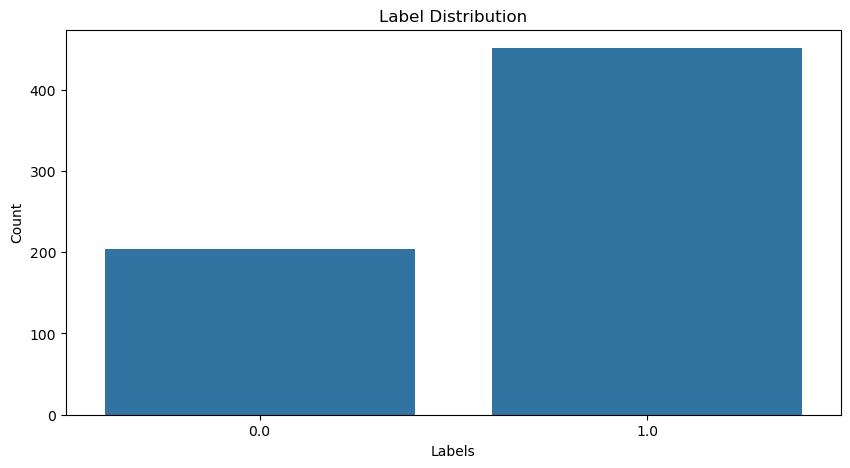

2025-03-27 14:54:15,313 - INFO - Saved figure to: /home/gentroyal/outreachy-temp/data/figures/hERG/label_distribution.png


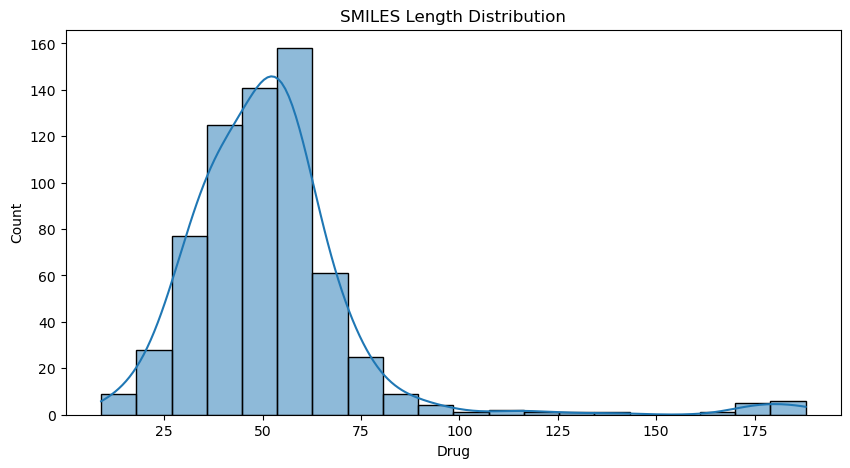

2025-03-27 14:54:15,672 - INFO - Saved figure to: /home/gentroyal/outreachy-temp/data/figures/hERG/smiles_length.png
2025-03-27 14:54:15,673 - INFO - EDA for hERG completed successfully.


In [8]:
explore = ExploratoryDataAnalysis(dataset_name)
explore.generate_eda()

**Comment:** There are 451 blockers (classed as 1) and and 204 nonblockers (classed as 0). Since there is a huge difference in the number of samples in both classes, it means that there is an imbalance and we need to address this before we can train our machine learning model.

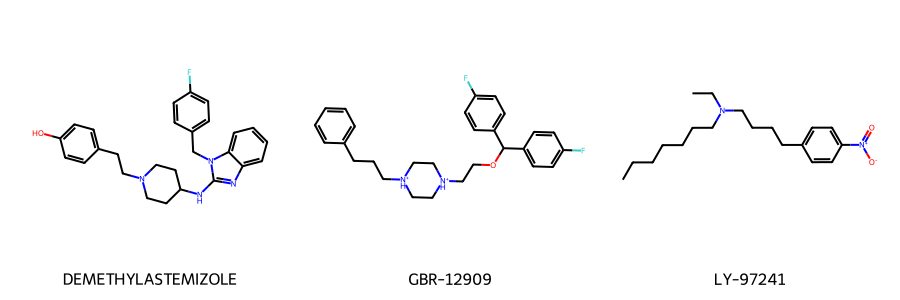

In [9]:
smiles_list = df["Drug"].iloc[:3].tolist()  # First 3 SMILES
drug_names = df["Drug_ID"].iloc[:3].tolist()  # Their  Names

mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
Draw.MolsToGridImage(mols, molsPerRow = 3, subImgSize=(300, 300), legends=drug_names)

**Comment:** 

In [10]:
model_name = "eos5guo"
!ersilia fetch $model_name #Uncomment this line if model has not been fetched

⬇️  Fetching model eos5guo: erg-descs
👎 Model eos5guo failed to fetch! Model already exists on your system. If you want to fetch it again, please delete the existing model first.


### **Featurizer**  

In [11]:
count = len(glob(f"../data/{dataset_name}/*{model_name}_featurized*"))
files = ['train', 'test', 'validation']

print("\nPerforming Featurisation...")
if count == 0:
    featurizer = Featurizer(model_id = model_name)
    
    for file in files:
        output_path = featurizer.featurize(input_file = file, dataset_name = dataset_name)
else:
    print("\nData has already by Featurised...")


Performing Featurisation...

Data has already by Featurised...


### Building a ML Model

In [53]:
def load_featurised_dataset(model_name):
    featurised_partition = [f"../data/{dataset_name}/{key}_{model_name}_featurized.csv" for key in splits.keys()]
    train = pd.read_csv(featurised_partition[0])
    train.drop(columns = ['key', 'input'], inplace = True)
    validation = pd.read_csv(featurised_partition[1])
    validation.drop(columns = ['key', 'input'], inplace = True)
    test = pd.read_csv(featurised_partition[2])
    test.drop(columns = ['key', 'input'], inplace = True)

    return train, validation, test

In [54]:
def split_features_label(df, target = 'Y'):
    X = df.drop(columns = [target])
    y = df[target]

    if model_name == 'eos24ci':
        new_cols = X.columns.tolist()
        xters = [chr(char) for char in range(ord('a'), ord('z') + 1)][:10]
        
        for i, (char, col) in enumerate(zip(X.columns[-10:], xters)):
            new_cols[-10 + i] = char[:-1] + col  # Replace only the last character
        
        X.columns = new_cols
        nan_rows = X.isna().sum(axis=1) > 0
        if nan_rows.any():
            index = X[nan_rows].index[0]  # Get the first index with NaN
            X = X.drop(index, axis=0)
            y = y.drop(index, axis=0)

    return X, y

In [55]:
model_name = 'eos5guo' #eos24ci
train, validation, test = load_featurised_dataset(model_name)

In [56]:
target = 'Y'
X_train, y_train = split_features_label(train, target)
X_test, y_test = split_features_label(test, target)
X_val, y_val = split_features_label(validation, target)
X_train.head()

,dimension_000,dimension_001,dimension_002,dimension_003,dimension_004,dimension_005,dimension_006,dimension_007,dimension_008,dimension_009,dimension_010,dimension_011,dimension_012,dimension_013,dimension_014,dimension_015,dimension_016,dimension_017,dimension_018,dimension_019,dimension_020,dimension_021,dimension_022,dimension_023,dimension_024,dimension_025,dimension_026,dimension_027,dimension_028,dimension_029,dimension_030,dimension_031,dimension_032,dimension_033,dimension_034,dimension_035,dimension_036,dimension_037,dimension_038,dimension_039,dimension_040,dimension_041,dimension_042,dimension_043,dimension_044,dimension_045,dimension_046,dimension_047,dimension_048,dimension_049,dimension_050,dimension_051,dimension_052,dimension_053,dimension_054,dimension_055,dimension_056,dimension_057,dimension_058,dimension_059,dimension_060,dimension_061,dimension_062,dimension_063,dimension_064,dimension_065,dimension_066,dimension_067,dimension_068,dimension_069,dimension_070,dimension_071,dimension_072,dimension_073,dimension_074,dimension_075,dimension_076,dimension_077,dimension_078,dimension_079,dimension_080,dimension_081,dimension_082,dimension_083,dimension_084,dimension_085,dimension_086,dimension_087,dimension_088,dimension_089,dimension_090,dimension_091,dimension_092,dimension_093,dimension_094,dimension_095,dimension_096,dimension_097,dimension_098,dimension_099,dimension_100,dimension_101,dimension_102,dimension_103,dimension_104,dimension_105,dimension_106,dimension_107,dimension_108,dimension_109,dimension_110,dimension_111,dimension_112,dimension_113,dimension_114,dimension_115,dimension_116,dimension_117,dimension_118,dimension_119,dimension_120,dimension_121,dimension_122,dimension_123,dimension_124,dimension_125,dimension_126,dimension_127,dimension_128,dimension_129,dimension_130,dimension_131,dimension_132,dimension_133,dimension_134,dimension_135,dimension_136,dimension_137,dimension_138,dimension_139,dimension_140,dimension_141,dimension_142,dimension_143,dimension_144,dimension_145,dimension_146,dimension_147,dimension_148,dimension_149,dimension_150,dimension_151,dimension_152,dimension_153,dimension_154,dimension_155,dimension_156,dimension_157,dimension_158,dimension_159,dimension_160,dimension_161,dimension_162,dimension_163,dimension_164,dimension_165,dimension_166,dimension_167,dimension_168,dimension_169,dimension_170,dimension_171,dimension_172,dimension_173,dimension_174,dimension_175,dimension_176,dimension_177,dimension_178,dimension_179,dimension_180,dimension_181,dimension_182,dimension_183,dimension_184,dimension_185,dimension_186,dimension_187,dimension_188,dimension_189,dimension_190,dimension_191,dimension_192,dimension_193,dimension_194,dimension_195,dimension_196,dimension_197,dimension_198,dimension_199,dimension_200,dimension_201,dimension_202,dimension_203,dimension_204,dimension_205,dimension_206,dimension_207,dimension_208,dimension_209,dimension_210,dimension_211,dimension_212,dimension_213,dimension_214,dimension_215,dimension_216,dimension_217,dimension_218,dimension_219,dimension_220,dimension_221,dimension_222,dimension_223,dimension_224,dimension_225,dimension_226,dimension_227,dimension_228,dimension_229,dimension_230,dimension_231,dimension_232,dimension_233,dimension_234,dimension_235,dimension_236,dimension_237,dimension_238,dimension_239,dimension_240,dimension_241,dimension_242,dimension_243,dimension_244,dimension_245,dimension_246,dimension_247,dimension_248,dimension_249,dimension_250,dimension_251,dimension_252,dimension_253,dimension_254,dimension_255,dimension_256,dimension_257,dimension_258,dimension_259,dimension_260,dimension_261,dimension_262,dimension_263,dimension_264,dimension_265,dimension_266,dimension_267,dimension_268,dimension_269,dimension_270,dimension_271,dimension_272,dimension_273,dimension_274,dimension_275,dimension_276,dimension_277,dimension_278,dimension_279,dimension_280,dimension_281,dimension_282,dimension_283,dimension_284,dimension

#### XGBoost Classifier

In [57]:
def train_xgboost(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Trains an XGBoost classifier and evaluates it on validation and test sets.

    Parameters:
    - X_train, y_train: Training dataset
    - X_val, y_val: Validation dataset
    - X_test, y_test: Test dataset

    Returns:
    - model_xgb: The trained XGBoost model
    """

    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1] # Handle class imbalance

    model_xgb = XGBClassifier(
        n_estimators=500,  
        learning_rate=0.05,  
        max_depth=6,  
        colsample_bytree=0.8,  
        subsample=0.8,  
        early_stopping_rounds=30,
        scale_pos_weight=scale_pos_weight,  
        eval_metric="logloss",  
        random_state=42  
    )

    model_xgb.fit(
        X_train, y_train,
        eval_set = [(X_train, y_train), (X_val, y_val)],
        verbose = 10
    )

    y_val_pred = model_xgb.predict(X_val)
    y_val_proba = model_xgb.predict_proba(X_val)[:, 1]
    
    print("\nValidation Set Evaluation:")
    print("ROC AUC Score:", roc_auc_score(y_val, y_val_proba))
    print(classification_report(y_val, y_val_pred))

    y_test_pred = model_xgb.predict(X_test)
    y_test_proba = model_xgb.predict_proba(X_test)[:, 1]

    print("\nTest Set Evaluation:")
    print("ROC AUC Score:", roc_auc_score(y_test, y_test_proba))
    print(classification_report(y_test, y_test_pred))

    return model_xgb

model_xgb = train_xgboost(X_train, y_train, X_val, y_val, X_test, y_test)

[0]	validation_0-logloss:0.67184	validation_1-logloss:0.68379
[10]	validation_0-logloss:0.50690	validation_1-logloss:0.62021
[20]	validation_0-logloss:0.41135	validation_1-logloss:0.59402
[30]	validation_0-logloss:0.34363	validation_1-logloss:0.58782
[40]	validation_0-logloss:0.29511	validation_1-logloss:0.57328
[50]	validation_0-logloss:0.25845	validation_1-logloss:0.57403
[60]	validation_0-logloss:0.23382	validation_1-logloss:0.57736
[70]	validation_0-logloss:0.21390	validation_1-logloss:0.57109
[80]	validation_0-logloss:0.19516	validation_1-logloss:0.57973
[90]	validation_0-logloss:0.18230	validation_1-logloss:0.58752
[100]	validation_0-logloss:0.17053	validation_1-logloss:0.59271

Validation Set Evaluation:
ROC AUC Score: 0.7519047619047619
              precision    recall  f1-score   support

         0.0       0.62      0.64      0.63        25
         1.0       0.78      0.76      0.77        42

    accuracy                           0.72        67
   macro avg       0.70    

#### RandomForestClassifier

In [58]:
def train_random_forest(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Trains a RandomForestClassifier and evaluates it on validation and test sets.

    Parameters:
    - X_train, y_train: Training dataset
    - X_val, y_val: Validation dataset
    - X_test, y_test: Test dataset

    Returns:
    - model: The trained RandomForestClassifier
    """

    rf_model = RandomForestClassifier(
        n_estimators=300, 
        max_depth=20,  
        min_samples_split=5,
        min_samples_leaf=10,
        max_features="sqrt",  
        class_weight="balanced",
        random_state=42,
        n_jobs=-1  
    )

    rf_model.fit(X_train, y_train)

    y_val_pred = rf_model.predict(X_val)
    y_val_proba = rf_model.predict_proba(X_val)[:, 1]

    print("\nValidation Set Evaluation:")
    print("ROC AUC Score:", roc_auc_score(y_val, y_val_proba))
    print(classification_report(y_val, y_val_pred))

    y_test_pred = rf_model.predict(X_test)
    y_test_proba = rf_model.predict_proba(X_test)[:, 1]

    print("\nTest Set Evaluation:")
    print("ROC AUC Score:", roc_auc_score(y_test, y_test_proba))
    print(classification_report(y_test, y_test_pred))

    return rf_model

rf_model = train_random_forest(X_train, y_train, X_val, y_val, X_test, y_test)


Validation Set Evaluation:
ROC AUC Score: 0.8128571428571428
              precision    recall  f1-score   support

         0.0       0.80      0.64      0.71        25
         1.0       0.81      0.90      0.85        42

    accuracy                           0.81        67
   macro avg       0.80      0.77      0.78        67
weighted avg       0.81      0.81      0.80        67


Test Set Evaluation:
ROC AUC Score: 0.8221104231166151
              precision    recall  f1-score   support

         0.0       0.61      0.66      0.63        38
         1.0       0.87      0.84      0.86       102

    accuracy                           0.79       140
   macro avg       0.74      0.75      0.74       140
weighted avg       0.80      0.79      0.80       140

